# New York City Taxi Trip Duration

В этом ноутбуке мы опишем создание регрессионной модели для решения задачи, поставленной на соревновании Kaggle
(https://www.kaggle.com/competitions/nyc-taxi-trip-duration/). Нам предлагается предсказывать продолжительность поездки такси Нью-Йорка по следующим параметрам:

    id - уникальный идентификатор каждой поездки,
    vendor_id — код, указывающий провайдера, связанного с записью о поездке,
    pickup_datetime — дата и время включения счетчика,
    dropoff_datetime — дата и время отключения счетчика,
    passenger_count - количество пассажиров в транспортном средстве (значение, введенное водителем),
    pickup_longitude — долгота, на которой был задействован счетчик,
    pickup_latitude — широта, на которой был включен счетчик,
    dropoff_longitude — долгота, на которой счетчик был отключен,
    dropoff_latitude — широта, на которой счетчик был отключен,
    store_and_fwd_flag — этот флаг указывает, хранилась ли запись о поездке в памяти автомобиля перед отправкой продавцу (у автомобиля не было соединения с сервером) — Y = поездка записана и переслана; N = поездка не хранилась,
    trip_duration - продолжительность поездки в секундах.



## 1. Подготовка

### 1) Библиотеки и данные

Подключаем необходимые модули, загружаем данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style='darkgrid', palette='rainbow')

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['savefig.format'] = 'pdf'

import warnings
warnings.simplefilter("ignore")

In [3]:
# !pip install folium
import folium

In [4]:
data = pd.read_csv('train.csv')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 2) Исследуем данные нам признаки

Давайте взглянем на признаки, данные нам в таблице:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


В нашем случае таргетом будет trip_duration, остальные колонки будем рассматривать как признаки. У нас есть $4$ категориальных признака, $2$ из которых — id и dropoff_datetime — являются служебными и при обучении нам скорее всего не пригодятся. Остальные признаки надо будет обработать и преобразовать.

### 3) Нулевые значения

Проверим данные на наличие пропусков.

In [6]:
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Потрясающе!

## 2. Предобработка

### 1) Удаление / создание признаков

1. Давайте избавимся от упомянутых выше колонок id и dropoff_datetime: маловероятно, что идентификатор поездки коррелирует с нашим таргетом, а время окончания поездки нам не поможет: его не будет на тестовой выборке, а предсказывать нам в любом случае придётся продолжительность поездки.

In [7]:
data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)

2. В соревновании в качестве оценочной метрики используется RMSLE, но вместо того, чтобы обучать модель, минимизирующую RMSLE, мы создадим модель, минимизирующую RMSE, при этом заменим таргет $y$ на $\log(y+1)$.

In [8]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])

3. Напрямую работать с признаком pickup_datetime неудобно, поэтому выделим из него месяц, день недели и час, когда поездка началась.

In [9]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['month'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour

data.drop('pickup_datetime', axis=1, inplace=True)

Давайте проанализируем взаимосвязь между таргетом и этими признаками. Посмотрим, как распределены поездки относительно часа и дня недели.

In [10]:
day_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

dof_distribution = data.groupby('day_of_week').size().reset_index(name='count')
dof_distribution['day_of_week'] = dof_distribution['day_of_week'].map(day_mapping)

hours_distribution = data.groupby('hour').size().reset_index(name='count')

dof_hour_distribution = data.groupby(['hour', 'day_of_week']).size().reset_index(name='count')
dof_hour_distribution['day_of_week'] = dof_hour_distribution['day_of_week'].map(day_mapping)


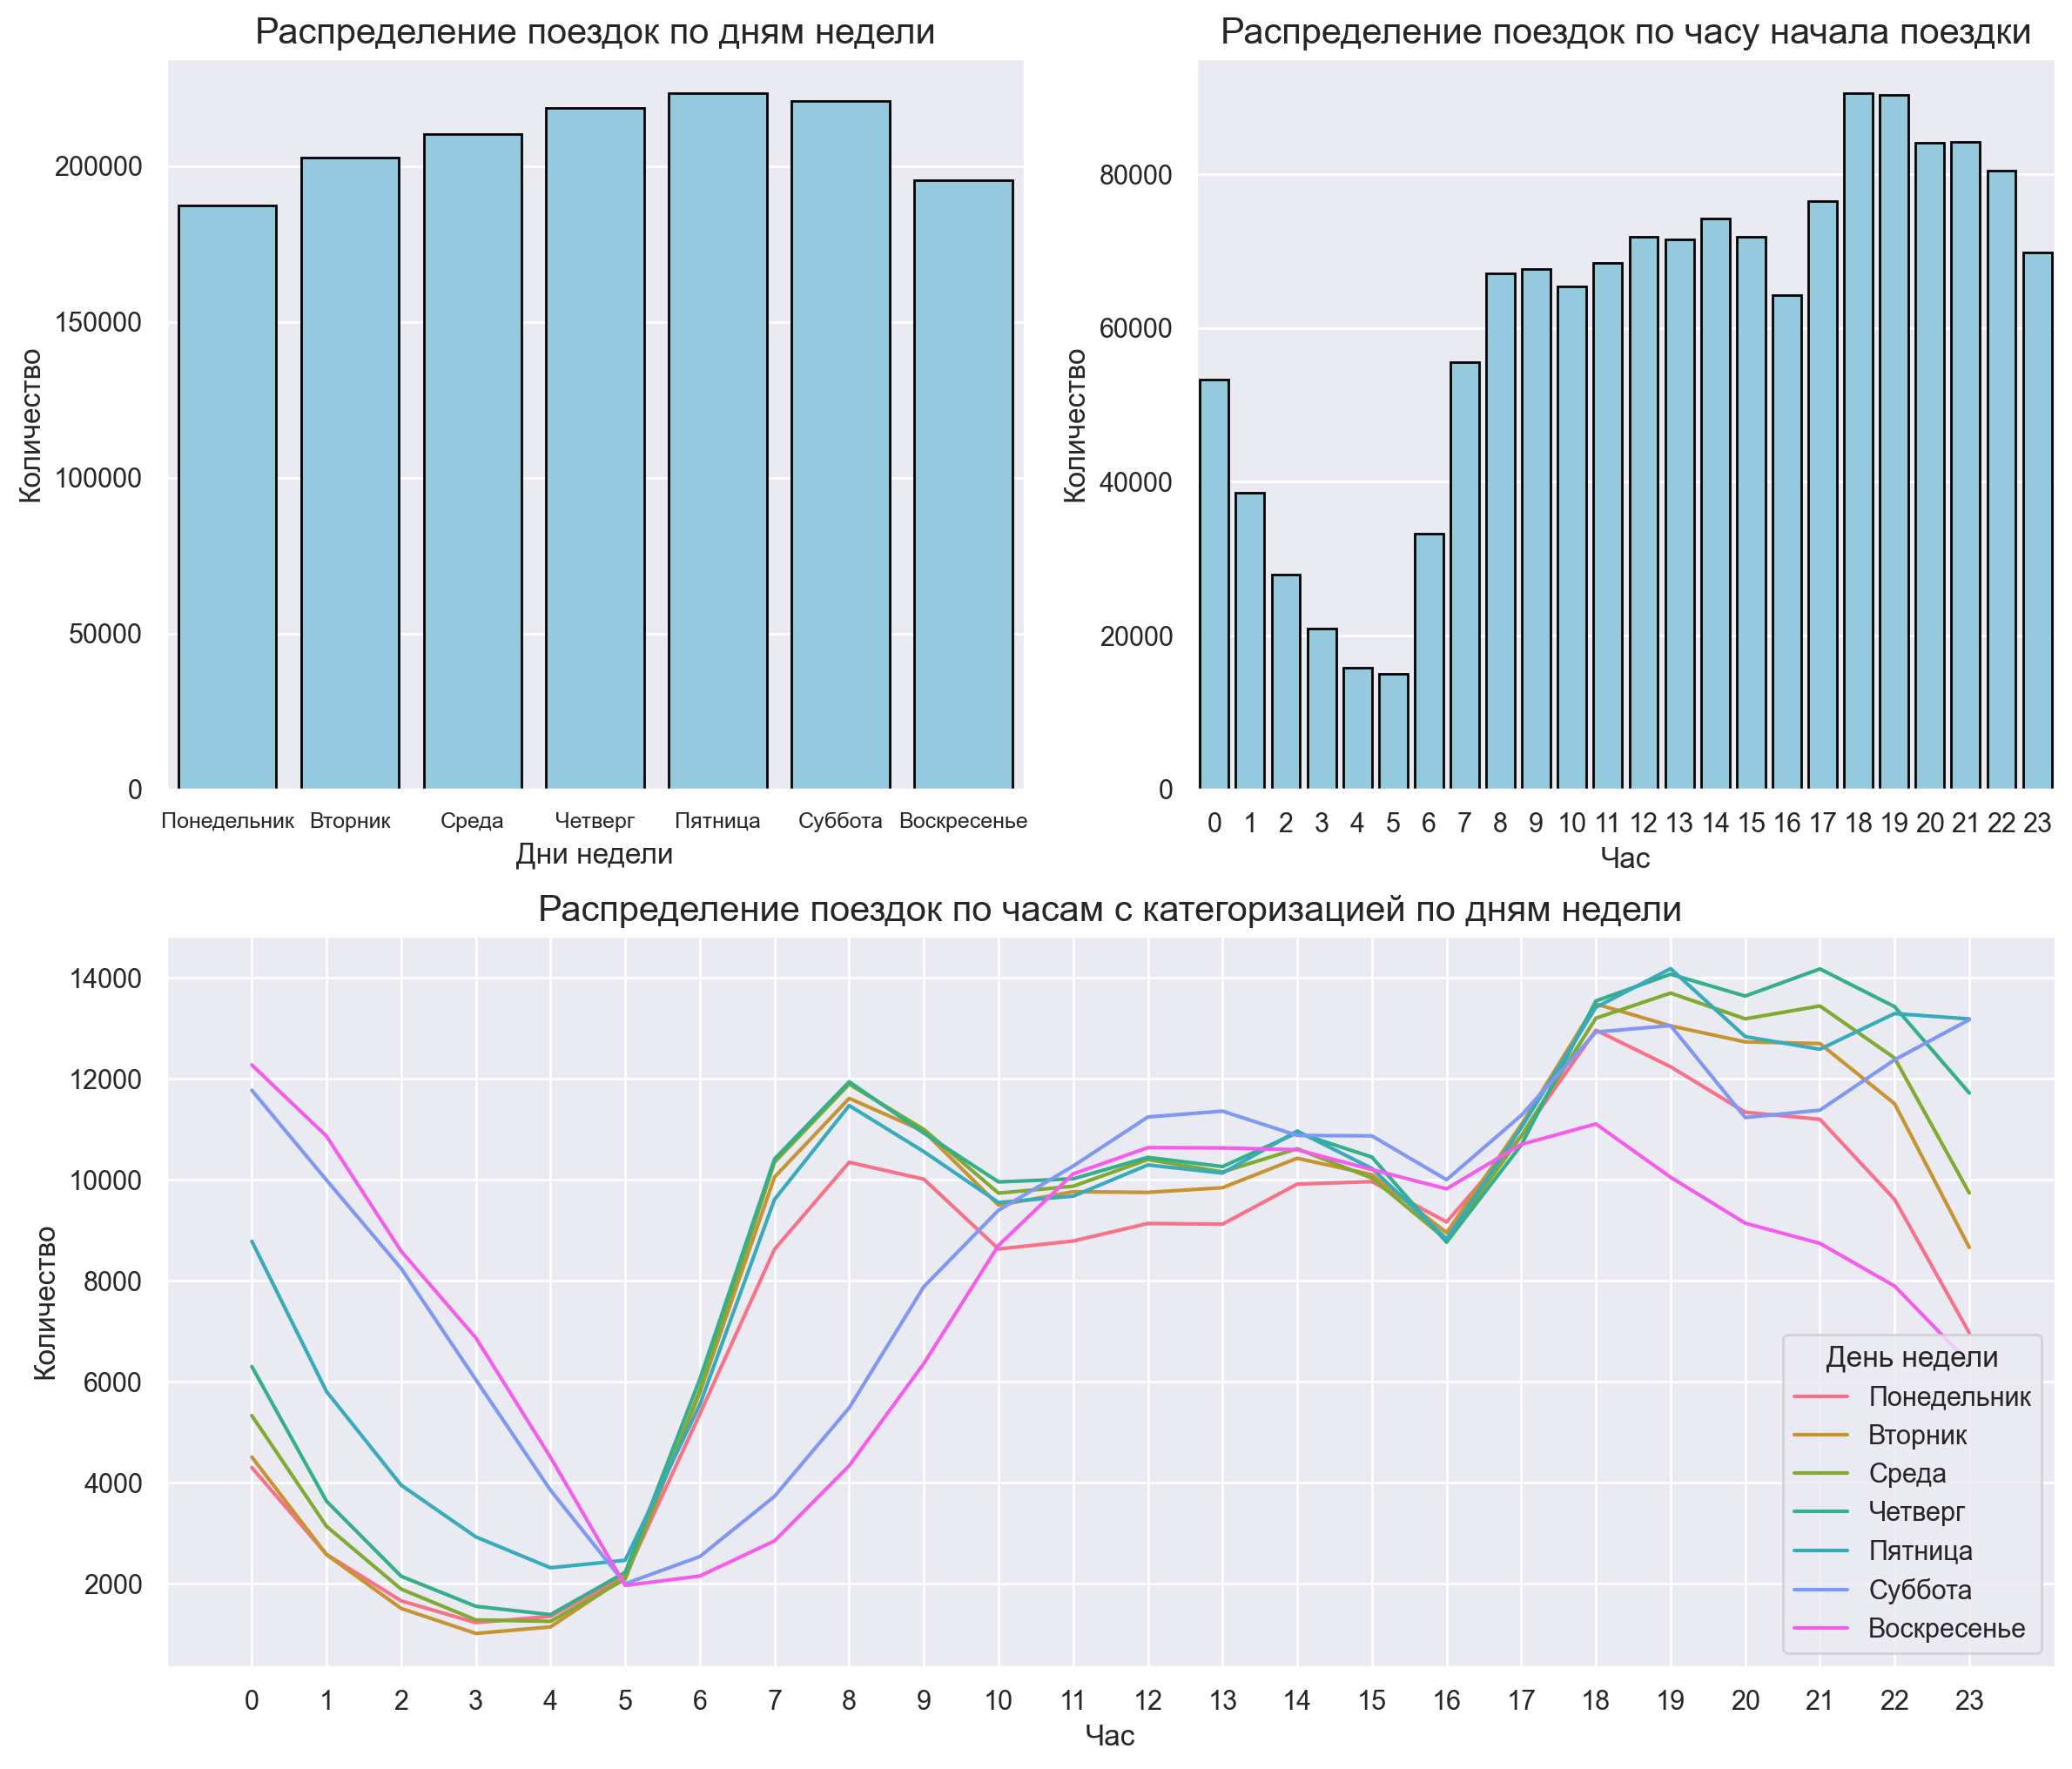

In [11]:
plt.figure(figsize=(14,12))

plt.subplot(2, 2, 1)
sns.barplot(data=dof_distribution, x='day_of_week', y='count', color='skyblue', edgecolor='black')
plt.title('Распределение поездок по дням недели', fontsize=15)
plt.xlabel('Дни недели', fontsize=12)
plt.xticks(fontsize=9)
plt.ylabel('Количество', fontsize=12)

plt.subplot(2, 2, 2)
sns.barplot(data=hours_distribution, x='hour', y='count', color='skyblue', edgecolor='black')
plt.title('Распределение поездок по часу начала поездки', fontsize=15)
plt.xlabel('Час', fontsize=12)
plt.ylabel('Количество', fontsize=12)

plt.subplot(2, 1, 2)
sns.lineplot(data=dof_hour_distribution, x='hour', y='count', hue='day_of_week')
plt.title('Распределение поездок по часам с категоризацией по дням недели', fontsize=15)
plt.xlabel('Час', fontsize=12)
plt.xticks(ticks=[i for i in range(24)])
plt.ylabel('Количество', fontsize=12)
plt.legend(title='День недели', loc='lower right')

plt.show()

Видно, что 1) есть различия в поездках в будние дни и на выходных; 2) вечером поездок больше, чем днём, а днём меньше, чем поздней ночью.

4. Добавим признак haversine (https://en.wikipedia.org/wiki/Haversine_formula), который будет равен расстоянию между началами и концами поездок. Вместе с тем учтём, что мы изменили таргет, и потому может быть полезным добивить признак $\log(1+h)$ — логарифм сферического расстояния $h$.

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    R = 6371.21
    return R * c

data['haversine'] = haversine(data['pickup_latitude'], data['pickup_longitude'],
                              data['dropoff_latitude'], data['dropoff_longitude'])
data['log_haversine'] = np.log1p(data['haversine'])

5. Подготовим трансформатор: посмотрим, как распределены координаты, поделим карту Нью-Йорка на регионы и присвоим каждой поездке регион начала и окончания. Если точка не попадает в указанную область, то присвоим региону значение -1.

In [13]:
data_sample = data.sample(500)

lat_center = (data_sample['pickup_latitude'].mean() + data_sample['dropoff_latitude'].mean()) / 2
lon_center = (data_sample['pickup_longitude'].mean() + data_sample['dropoff_longitude'].mean()) / 2

location = (lat_center, lon_center)
m = folium.Map(location=location, zoom_start=12)

for _, trip in data_sample.iterrows():
    folium.Circle(
        radius=50,
        location=(trip['pickup_latitude'], trip['pickup_longitude']),
        color='blue',
        fill_color='blue',
        fill=True
    ).add_to(m)
    
    folium.Circle(
        radius=50,
        location=(trip['dropoff_latitude'], trip['dropoff_longitude']),
        color='red',
        fill_color='red',
        fill=True
    ).add_to(m)

m

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lat_bins=10, lon_bins=10):
        self.lat_bins = lat_bins
        self.lon_bins = lon_bins
        
        # координаты взятой окрестности Нью-Йорка
        self.lat_min = 40.697720
        self.lon_min = -74.022606
        self.lat_max = 40.803466
        self.lon_max = -73.934027
        
        self.lat_step = (self.lat_max - self.lat_min) / lat_bins
        self.lon_step = (self.lon_max - self.lon_min) / lon_bins
    
    
    def fit(self, data=None):
        return self

    def _get_cell(self, lat, lon):
        valid_coords = (self.lat_min <= lat) & (lat <= self.lat_max) & (self.lon_min <= lon) & (lon <= self.lon_max)

        row = ((lat - self.lat_min) // self.lat_step).astype(int)
        col = ((lon - self.lon_min) // self.lon_step).astype(int)

        return np.where(valid_coords, row + col * self.lat_bins, -1)
    
    def transform(self, data):
        pickup_region = self._get_cell(data['pickup_latitude'], data['pickup_longitude'])
        dropoff_region = self._get_cell(data['dropoff_latitude'], data['dropoff_longitude'])

        transformed_data = data
        transformed_data['pickup_region'] = pickup_region
        transformed_data['dropoff_region'] = dropoff_region
        
        return transformed_data
    
    def show_map(self):
        lat_center = (self.lat_min + self.lat_max) / 2
        lon_center = (self.lon_min + self.lon_max) / 2
        location = (lat_center, lon_center)
        m = folium.Map(location=location, zoom_start=12)

        for row in range(self.lat_bins):
            for col in range(self.lon_bins):
                lat_min = self.lat_min + row * self.lat_step
                lat_max = self.lat_min + (row + 1) * self.lat_step
                lon_min = self.lon_min + col * self.lon_step
                lon_max = self.lon_min + (col + 1) * self.lon_step
                
                folium.Rectangle(
                    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
                    color='green',
                    fill=True,
                    fill_opacity=0.2,
                    weight=1,
                    popup=f'Region: {row + col * self.lat_bins}'
                ).add_to(m)

        return m

In [15]:
grid = MapGridTransformer()
data = grid.fit_transform(data)

MapGridTransformer().show_map()

6. Также добавим манхэттенское (или "таксистское") расстояние между началами и концами поездок. Мы знаем, что Нью-Йорк повёрнут на $\sim 29^{\circ}$ относительно меридианов, значит, мы можем провести прямые через точки начала и конца соответственно по улицам, по которым поехало бы такси, если бы оно совершало всего один поворот за поездку (максимум). Мы знаем по одной точке для прямых и их углы наклона относительно естественной системы координат (центр — пересечение экватора с нулевым меридианом, оси определены по экватору и меридиану). В таком случае точка пересечения этих прямых выражается как

$
\left\{
\begin{array}{ll}
x_m = \sin^2\alpha \cdot x_1 + \sin\alpha \cos\alpha \cdot (y_2 - y_1) + \cos^2\alpha \cdot x_2, \\ 
y_m = \sin^2\alpha \cdot y_2 + \sin\alpha \cos\alpha \cdot (x_2 - x_1) + \cos^2\alpha \cdot y_1,
\end{array}
\right.$

где $\alpha$ — угол наклона одной из прямых, $\alpha = 61^\circ$; $(x_1, y_1),~ (x_2, y_2)$ — координаты начал и концов. Так же, как и с haversine, добавим признак, равный $\log(1 + md)$, где $md$ — посчитанное нами манхэттенское расстояние. Стоит учитывать, что это не точное "таксистское" расстояние: всё-таки мы пренебрегаем тем, что живём на шаре (считаем, что город вытянут параллельно меридианам).

In [16]:
class ManhattanDistanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data=None):
        return self

    def transform(self, data):
        # угол наклона одной из прямых
        rotation_angle = np.radians(61)
        sin = np.sin(rotation_angle)
        cos = np.cos(rotation_angle)
        
        x_pickup = data['pickup_latitude']
        y_pickup = data['pickup_longitude']
        x_dropoff = data['dropoff_latitude']
        y_dropoff = data['dropoff_longitude']

        x_mid = np.square(sin) * x_pickup + sin * cos * (y_dropoff - y_pickup) + np.square(cos) * x_dropoff
        y_mid = np.square(sin) * y_dropoff + sin * cos * (x_dropoff - x_pickup) + np.square(cos) * y_pickup

        pickup_to_mid = haversine(x_pickup, y_pickup, x_mid, y_mid)
        mid_to_dropoff = haversine(x_mid, y_mid, x_dropoff, y_dropoff)

        transformed_data = data
        transformed_data['manhattan_dist'] = pickup_to_mid + mid_to_dropoff
        transformed_data['log_manhattan_dist'] = np.log1p(transformed_data['manhattan_dist'])
        
        return transformed_data


In [17]:
manhattan_transformer = ManhattanDistanceTransformer()
data = manhattan_transformer.fit_transform(data)

data.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

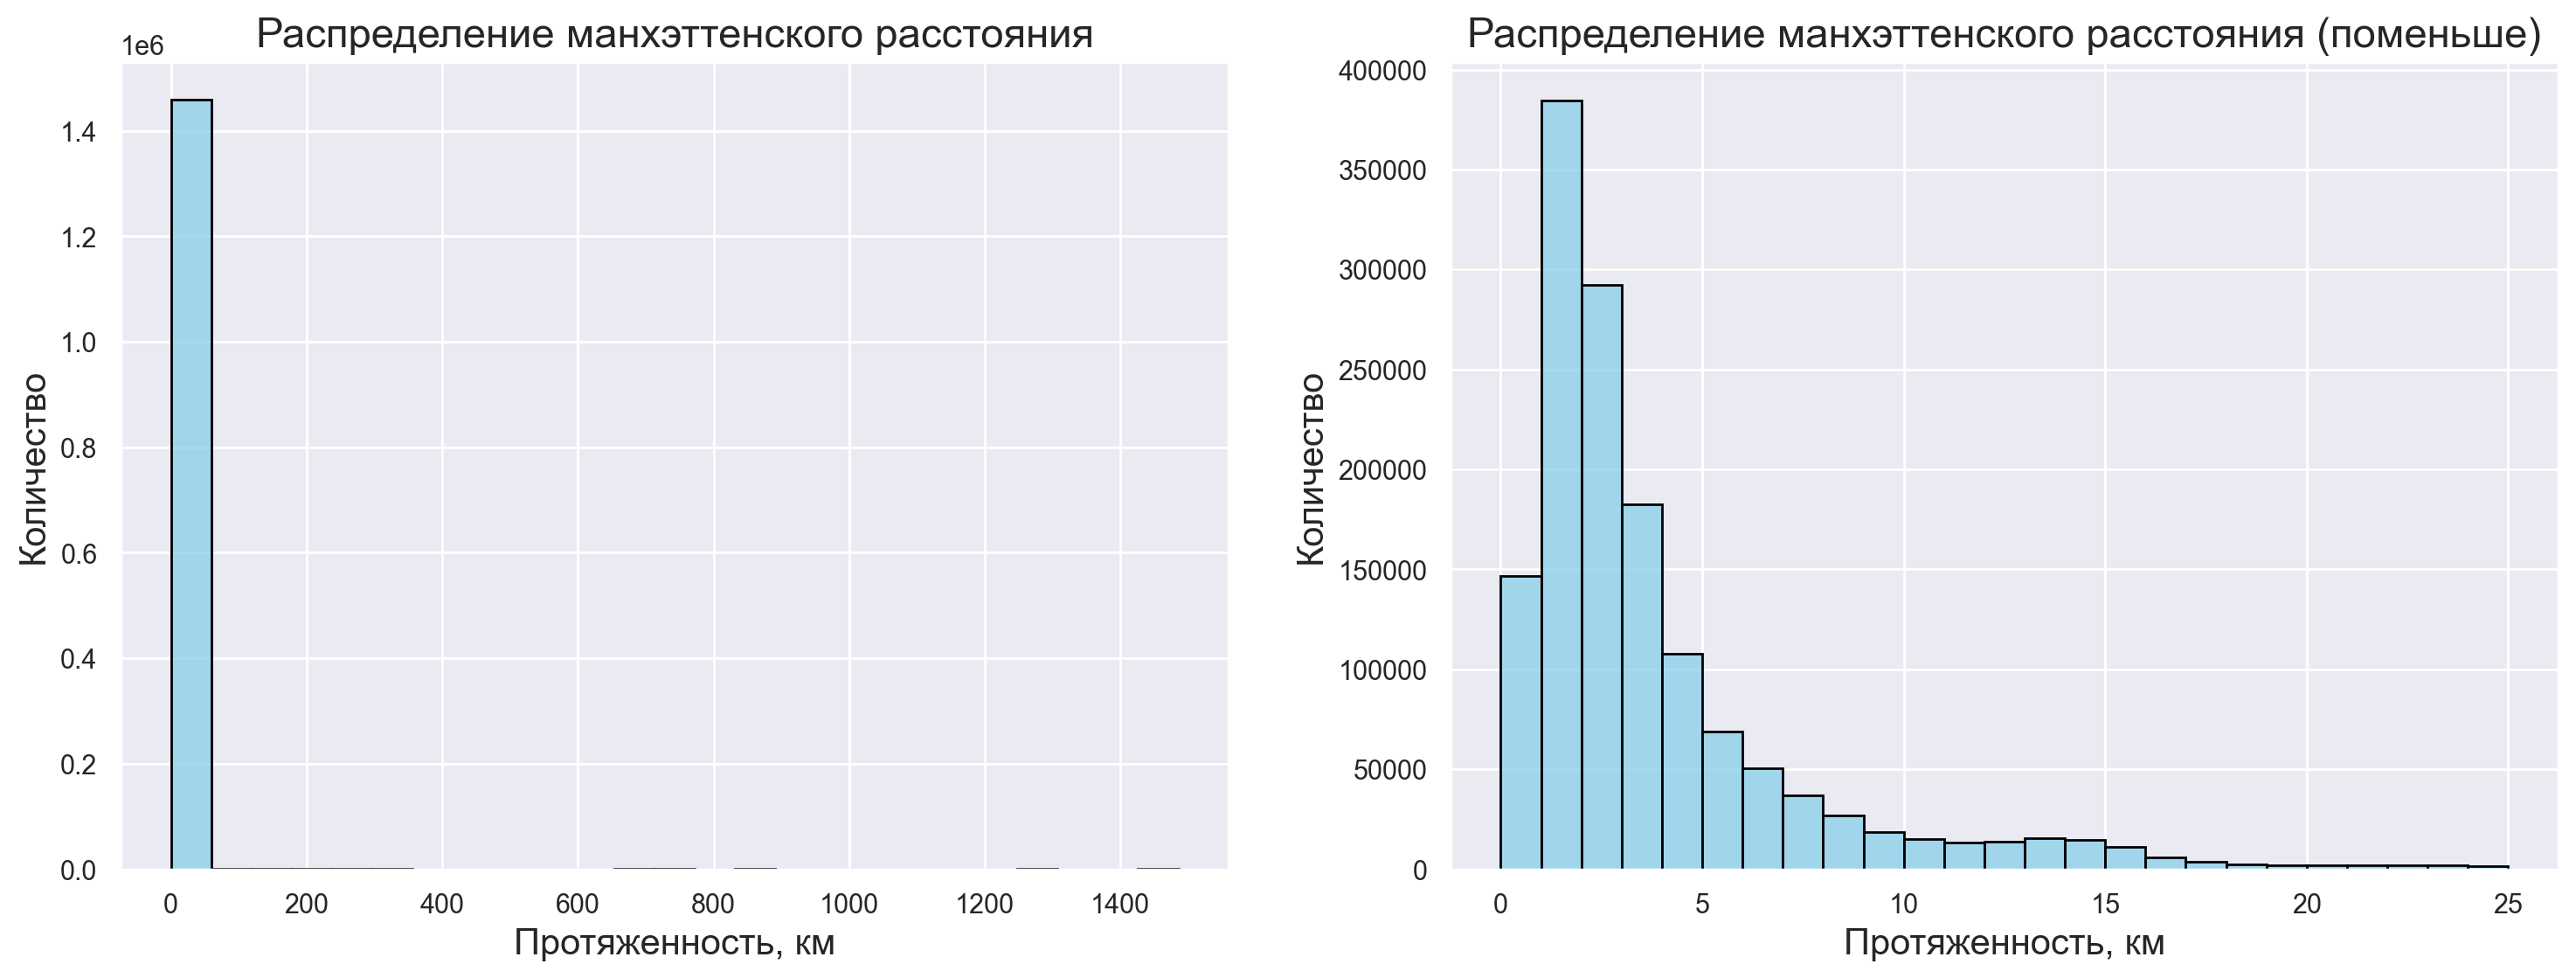

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sns.histplot(data['manhattan_dist'], bins=25, color='skyblue', edgecolor='black')
plt.title('Распределение манхэттенского расстояния', fontsize=17)
plt.xlabel('Протяженность, км', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.subplot(1, 2, 2)
sns.histplot(data['manhattan_dist'], bins=25, binrange=(0, 25), color='skyblue', edgecolor='black')
plt.title('Распределение манхэттенского расстояния (поменьше)', fontsize=17)
plt.xlabel('Протяженность, км', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.show()

7. Мы проанализировали длительности и протяженности поездок, т.е. путь и время — почему бы не рассмотреть скорость? Давайте посмотрим на средние скорости относительно дня недели и часа поездки и добавим новый признак — медианную скорость в данный день недели и час. ("Почему же не среднюю?" — вы спросите. Ответ прост: мы не убирали выбросы, которые могут сильно попортить среднюю скорость, поэтому она может сильно отличаться от наших ожиданий.)

In [19]:
# km / (s / (3600)) = km / h
data['speed'] = data['manhattan_dist'] / (data['trip_duration'] / 3600.0)
median_speed = data[['hour', 'day_of_week', 'speed']].groupby(['hour', 'day_of_week']).median().reset_index()

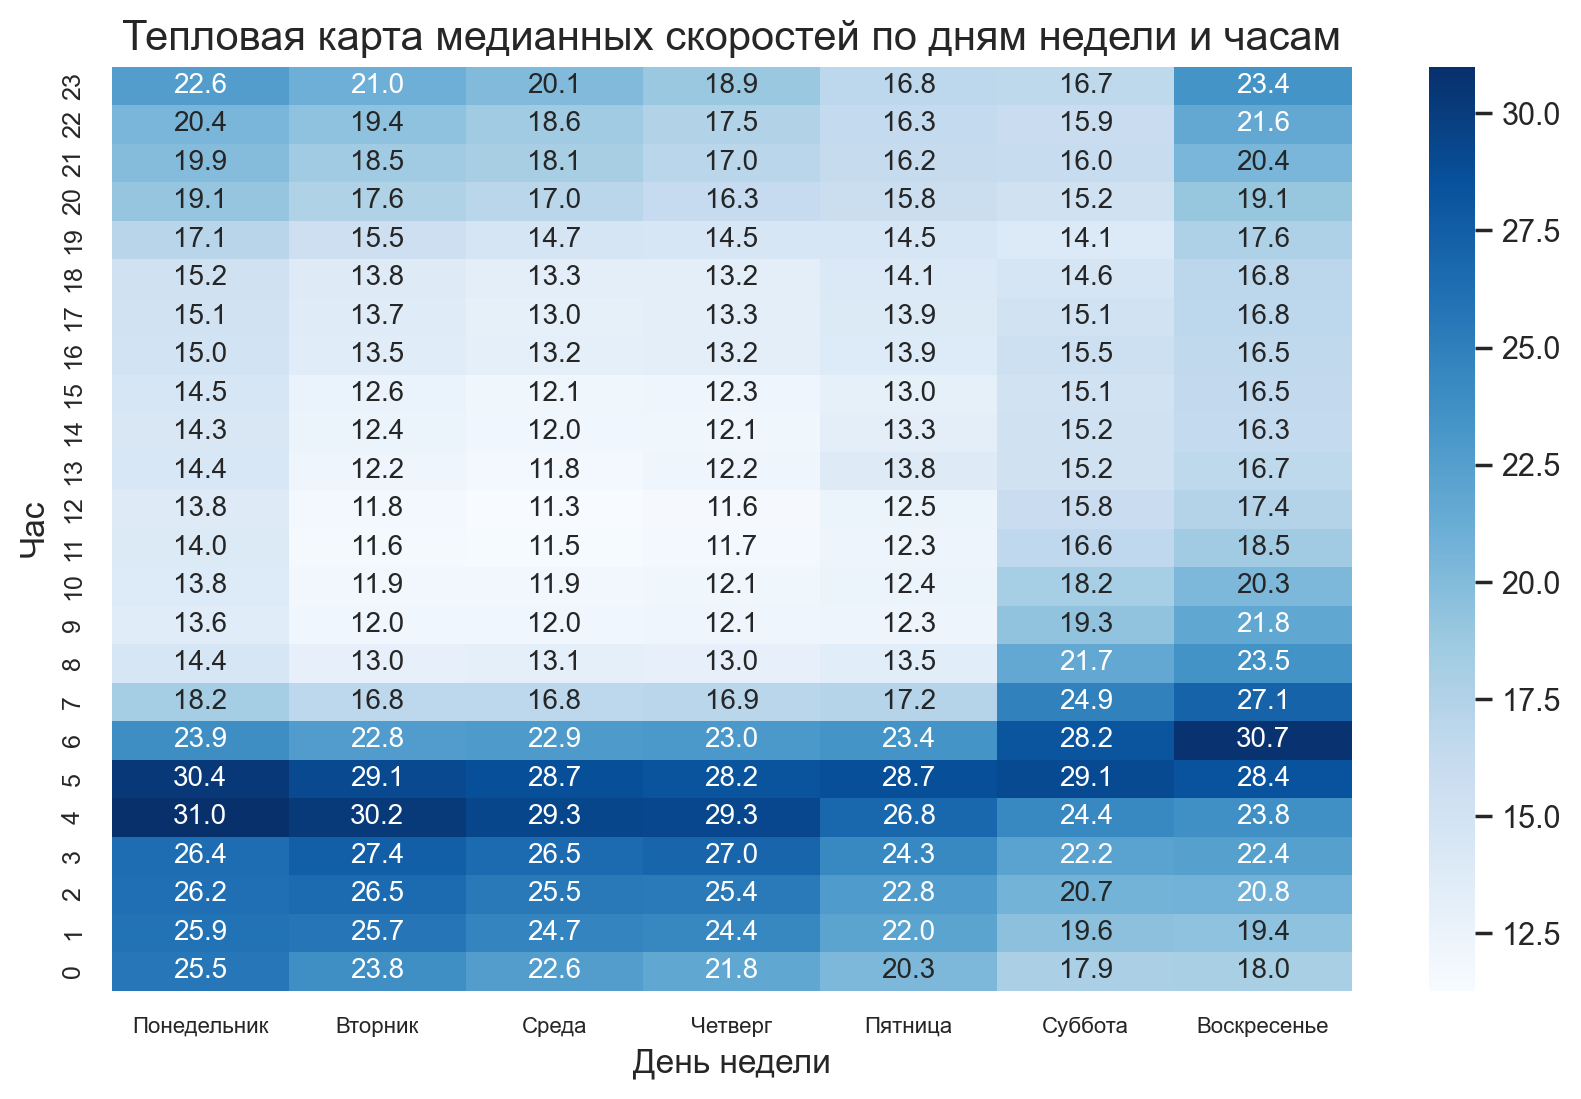

In [20]:
plt.figure(figsize=(10, 6))

pivot_table = median_speed.pivot_table(index='hour', columns='day_of_week', values='speed')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='Blues', annot_kws={"size": 10})

plt.title('Тепловая карта медианных скоростей по дням недели и часам', fontsize=15)
plt.xlabel('День недели', fontsize=12)
plt.xticks(ticks=[i + 0.5 for i in range(7)], labels=day_mapping.values(), fontsize=8)
plt.ylabel('Час', fontsize=12)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()

plt.show()

Неплохое и вполне резонное распределение: днём на дорогах больше машин (читать: трафик более интенсивен), соответственно, больше пробок и движение затруднено, ночью же наоборот. Теперь заметим, что наш таргет $\log(t+1)$ выражается через $S$ и $v$ — путь и скорость соответственно. В самом деле: $\log(t+1) = \log(\frac{S}{v} + 1) = \log(S+v) - \log(v)$, значит, имеет смысл добавить признаки $\log(v)$ и $\log(S+v)$ но есть нюанс: изначально таргет представлял собой время в секундах, значит, и скорость должна измеряться в км/с (манхэттенское расстояние уже выражено в км).

In [21]:
data['speed'] = data['manhattan_dist'] / data['trip_duration']

median_speed = data[['hour', 'day_of_week', 'speed']].groupby(['hour', 'day_of_week']).median().reset_index()
median_speed.rename(columns={'speed': 'median_speed'}, inplace=True)

data = pd.merge(data, median_speed, on=['day_of_week', 'hour'], how='left')
data.drop('speed', axis=1, inplace=True)

In [22]:
data['ln_median_speed'] = np.log(data['median_speed'])
data['ln_dist_speed'] = np.log(data['manhattan_dist'] + data['median_speed'])

8. Напоследок рассмотрим два признака: vendor_id и store_and_fwd_flag. У них всего по $2$ возможных значения, поэтому в контексте стандартизации признаков будет удобно добиться того, чтобы они принимали значения из множества $\{0, 1\}$.

In [23]:
data['vendor_id'] = data['vendor_id'] - 1
data['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 'N').astype(np.int64)

### 2) Выбросы

Как было замечено ранее, в выборке присутствуют аномальные значения тех или иных признаков, в связи с чем было бы логично почистить данные. Однако это ухудшит качество нашей модели (почти в полтора раза!), поскольку в тестовой выборке могут так же присутствовать выбросы, для которых мы бы хотели как можно точнее предсказывать таргет (как неожиданно). Посмотрим, как распределены протяженности и длительности поездок:

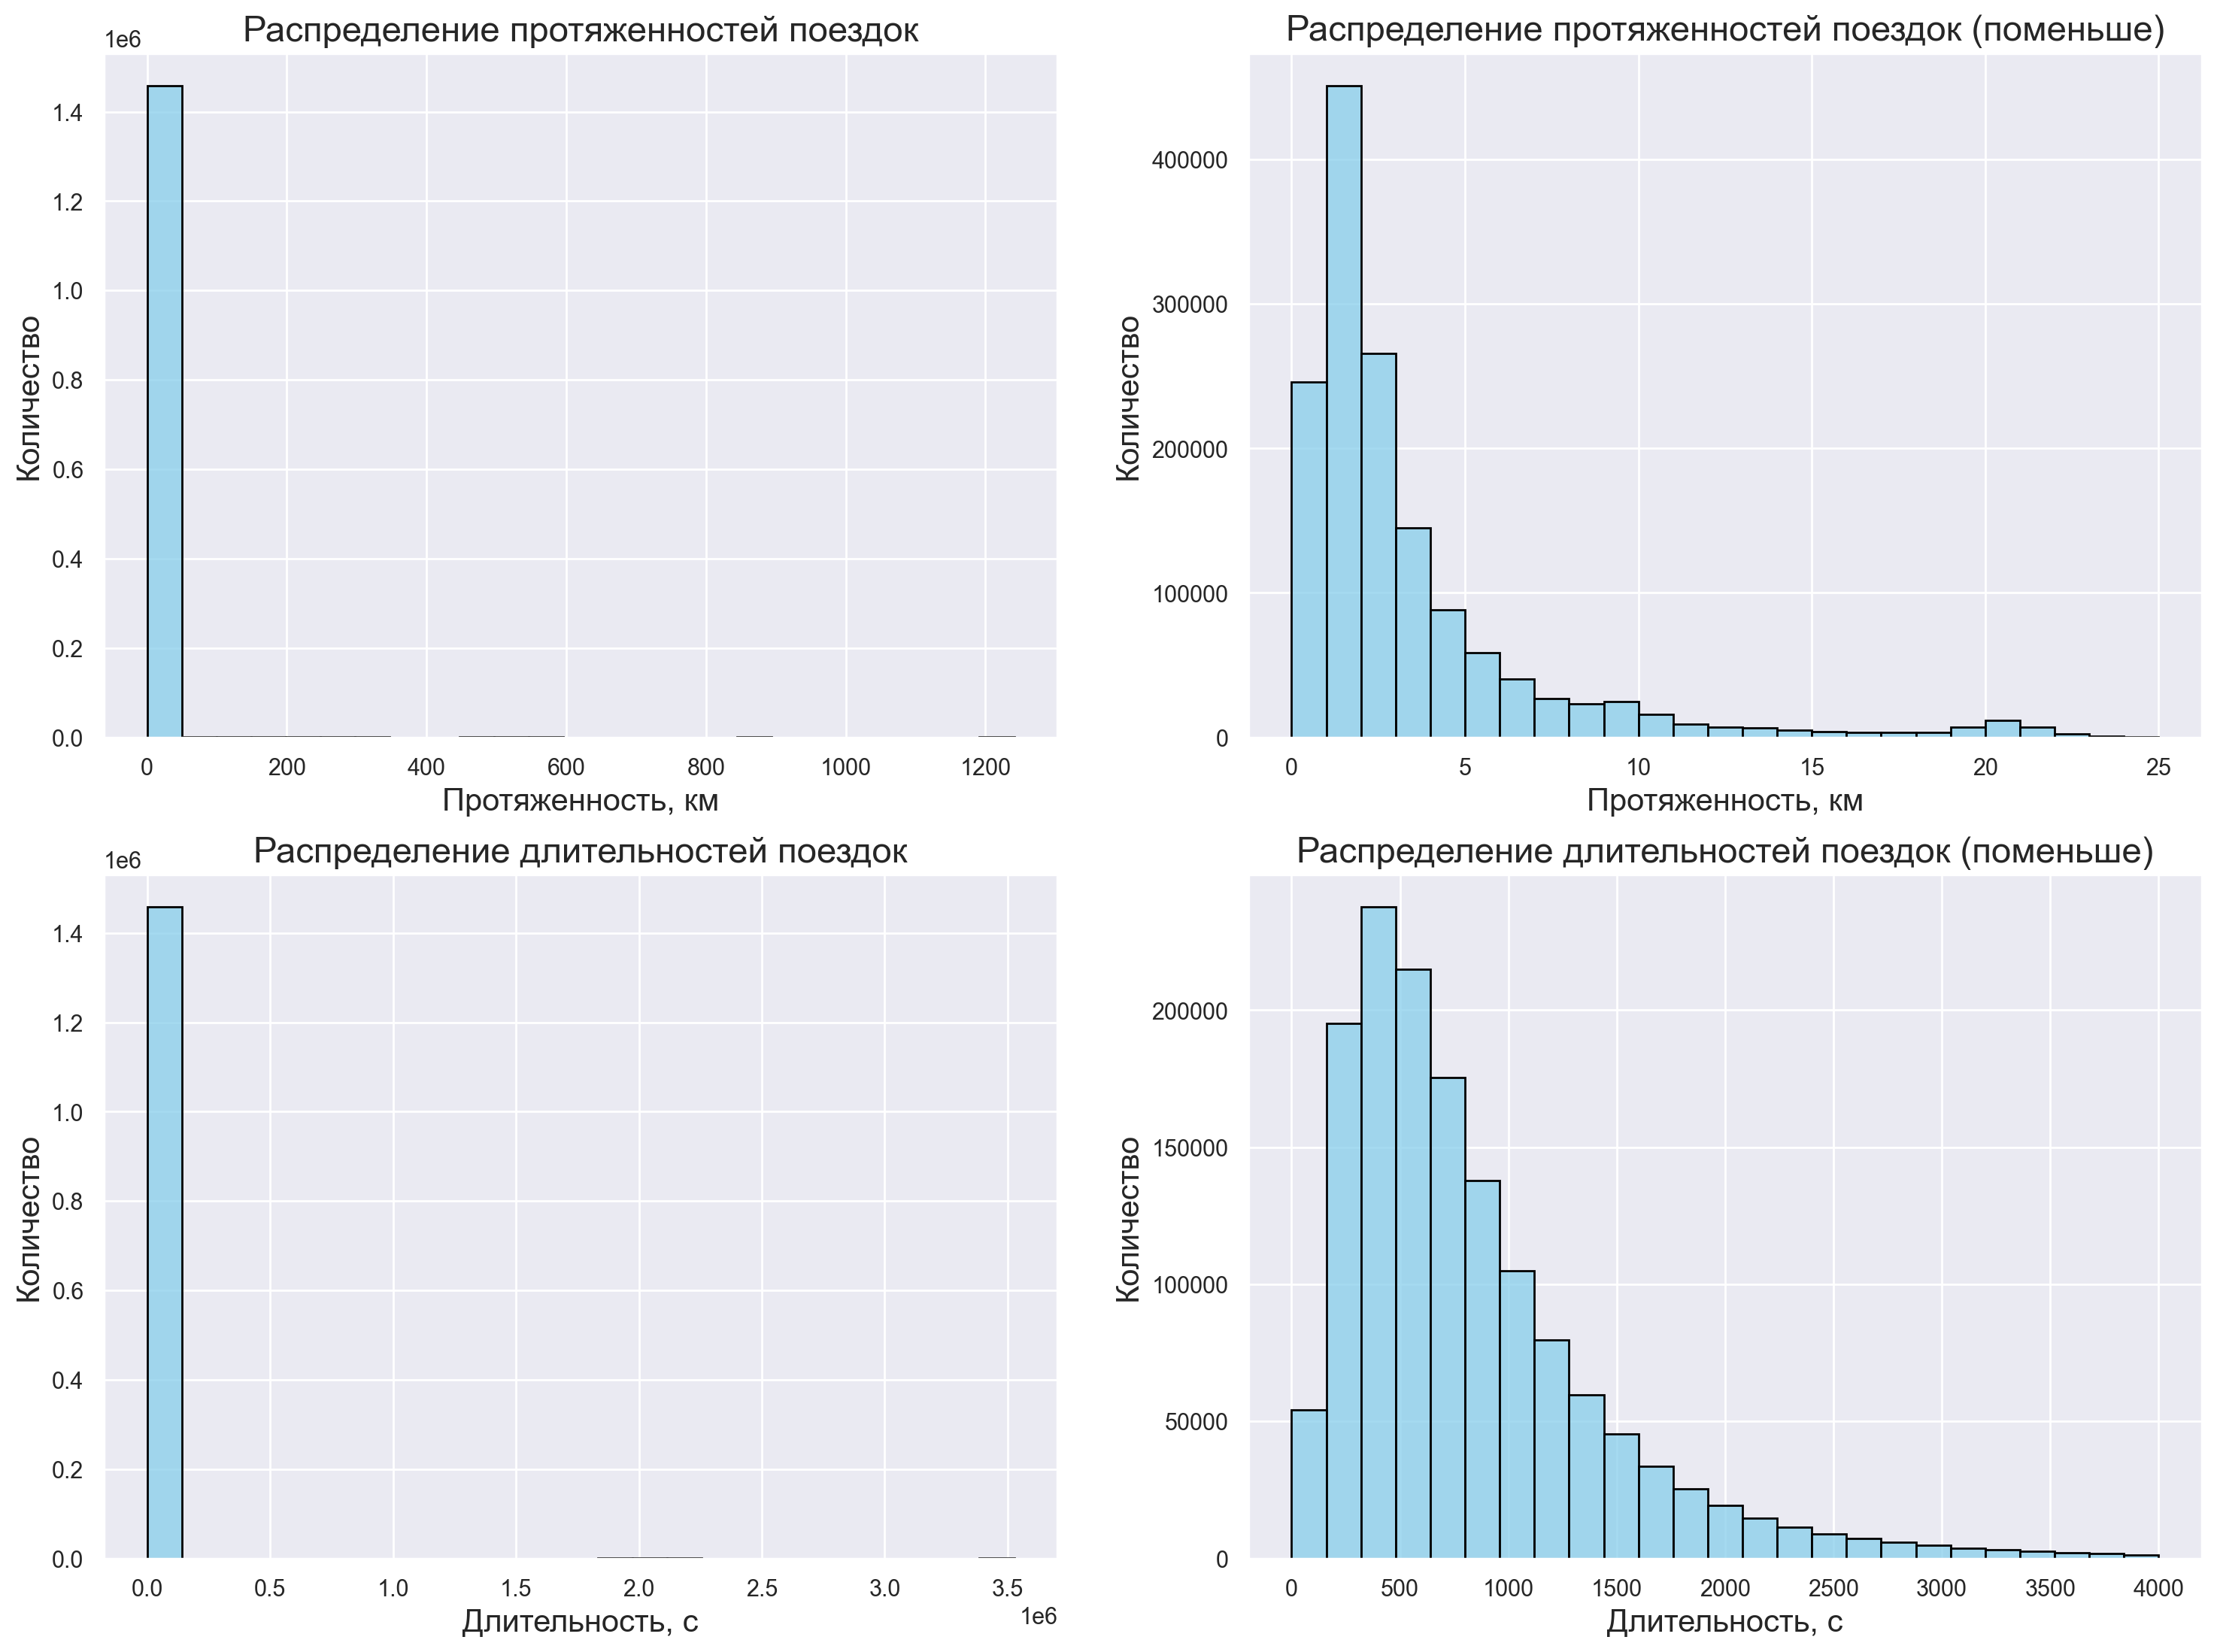

In [24]:
plt.figure(figsize=(18,13))

plt.subplot(2, 2, 1)
sns.histplot(data['haversine'], bins=25, color='skyblue', edgecolor='black')
plt.title('Распределение протяженностей поездок', fontsize=17)
plt.xlabel('Протяженность, км', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.subplot(2, 2, 2)
sns.histplot(data['haversine'], bins=25, binrange=(0, 25), color='skyblue', edgecolor='black')
plt.title('Распределение протяженностей поездок (поменьше)', fontsize=17)
plt.xlabel('Протяженность, км', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.subplot(2, 2, 3)
sns.histplot(data['trip_duration'], bins=25, color='skyblue', edgecolor='black')
plt.title('Распределение длительностей поездок', fontsize=17)
plt.xlabel('Длительность, c', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.subplot(2, 2, 4)
sns.histplot(data['trip_duration'], bins=25, binrange=(0, 4000), color='skyblue', edgecolor='black')
plt.title('Распределение длительностей поездок (поменьше)', fontsize=17)
plt.xlabel('Длительность, c', fontsize=15)
plt.ylabel('Количество', fontsize=15)

plt.show()

Есть как аномально длинные поездки ($>100$ км, $>10^6$ c), так и аномально короткие ($<1$ км, $<166$ с $\approx 3$ мин).

### 3) Корреляция

Посмотрим, как наши численные признаки коррелируют с таргетом.

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   passenger_count     1458644 non-null  int64  
 2   store_and_fwd_flag  1458644 non-null  int64  
 3   trip_duration       1458644 non-null  int64  
 4   log_trip_duration   1458644 non-null  float64
 5   month               1458644 non-null  int32  
 6   day_of_week         1458644 non-null  int32  
 7   hour                1458644 non-null  int32  
 8   haversine           1458644 non-null  float64
 9   log_haversine       1458644 non-null  float64
 10  pickup_region       1458644 non-null  int64  
 11  dropoff_region      1458644 non-null  int64  
 12  manhattan_dist      1458644 non-null  float64
 13  log_manhattan_dist  1458644 non-null  float64
 14  median_speed        1458644 non-null  float64
 15  ln_median_speed

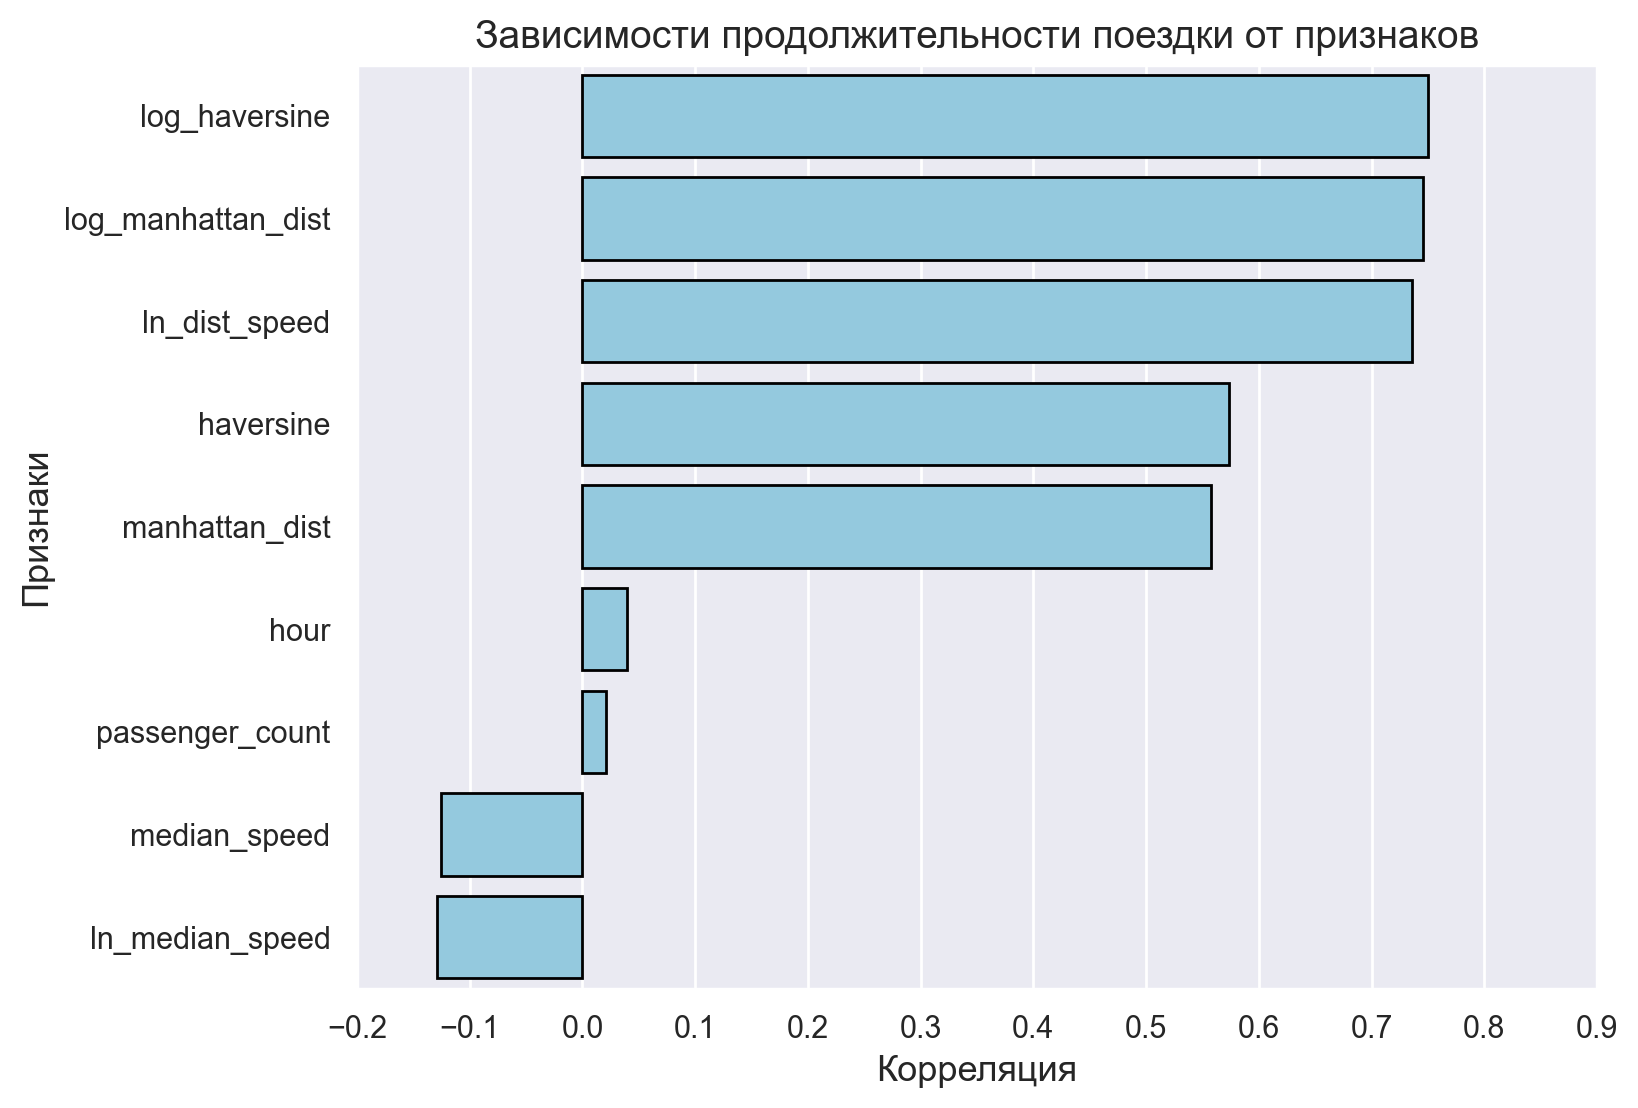

In [26]:
numeric_features = ['passenger_count', 'hour', 'haversine', 'log_haversine',
                    'manhattan_dist', 'log_manhattan_dist', 'median_speed',
                    'ln_median_speed', 'ln_dist_speed']

correlations = data[numeric_features].corrwith(data['log_trip_duration']).sort_values(ascending=False)

#sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', annot_kws={"size": 8})
sns.barplot(y=correlations.index, x=correlations, color='skyblue', edgecolor='black')
plt.title('Зависимости продолжительности поездки от признаков', fontsize=14)
plt.xlabel('Корреляция', fontsize=13)
plt.xticks(ticks=[i/10 for i in range(-2, 10)])
plt.ylabel('Признаки', fontsize=13)
plt.show()

Вполне очевидная прямая зависимость продолжительности поездки от расстояний и обратная — от скорости. В идеале у скорости корреляция с временем поездки была бы гораздо больше, чем получилась у нас; возможно, имеет смысл посчитать скорость как-то иначе, относительно других признаков, но имеем, что имеем.

## 3. Построение модели

Итак, данные подготовлены, осталось дело за малым.

### 1) Подготовка pipeline

Отделим таргет от признаков и разделим выборку на обучающую и тестовую в отношении $7:3$.

In [27]:
from sklearn.model_selection import train_test_split

X = data.drop(['log_trip_duration', 'trip_duration'], axis=1)
y = data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Подготовим простую линейную модельку из уже имеющихся данных: закодируем категориальные признаки, численные — отмасштабируем, посчитаем ошибку. Заметим, что признаки vendor_id и store_and_fwd_flag уже близки к стандартным значениям — их нормировать не будем. Поскольку мы работаем уже с логарифмами продолжительности (и предсказываем, получается, логарифм), то в качестве ошибки будем считать RMSE.

In [28]:
categorical_features = ['month', 'day_of_week', 'pickup_region', 'dropoff_region']

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plain_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LinearRegression())
])

plain_model = plain_pipeline.fit(X_train, y_train)
y_pred = plain_model.predict(X_test)

print("Тестовая RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Тестовая RMSE = 0.4622


В целом, неплохой результат: на соревновании с такой ошибкой мы бы оказались чуть ниже середины лидерборда. Давайте попробуем обучить ещё пару моделей с регуляризациями: Ridge и Lasso.

In [31]:
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

ridge_model = ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

print("Тестовая RMSE (Ridge) = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Тестовая RMSE (Ridge) = 0.4622


In [32]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

lasso_model = lasso_pipeline.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

print("Тестовая RMSE (Lasso) = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Тестовая RMSE (Lasso) = 0.7950


Увы, хотя, впрочем, ожидаемо: мы не подбирали коэффициенты для регуляризации и использовали значение $\alpha = 1$, которое стоит по умолчанию.

### 2) Подбор коэффициента $\alpha$

Поскольку $\alpha$ является гиперпараметром, попробуем подобрать $\alpha_{best}$ с помощью перебора с кросс-валидацией подходящий коэффициент для регуляризации и посмотрим, как изменятся ошибки на тестовой выборке. Для этого обозначим сетку значений, которые будут проверяться: пускай это будут $20$ чисел от $10^{-2}$ до ${10^4}$.

In [43]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 4, 20)
_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


searcher_ridge = GridSearchCV(ridge_pipeline, [{"regression__alpha": alphas}],
                              scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher_ridge.fit(X_valid, y_valid)
best_alpha_ridge = searcher_ridge.best_params_["regression__alpha"]

searcher_lasso = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                              scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
searcher_lasso.fit(X_valid, y_valid)
best_alpha_lasso = searcher_lasso.best_params_["regression__alpha"]


print(f"alpha (Ridge) = {best_alpha_ridge}")
print(f"alpha (Lasso) = {best_alpha_lasso}")

alpha (Ridge) = 2335.7214690901214
alpha (Lasso) = 0.01


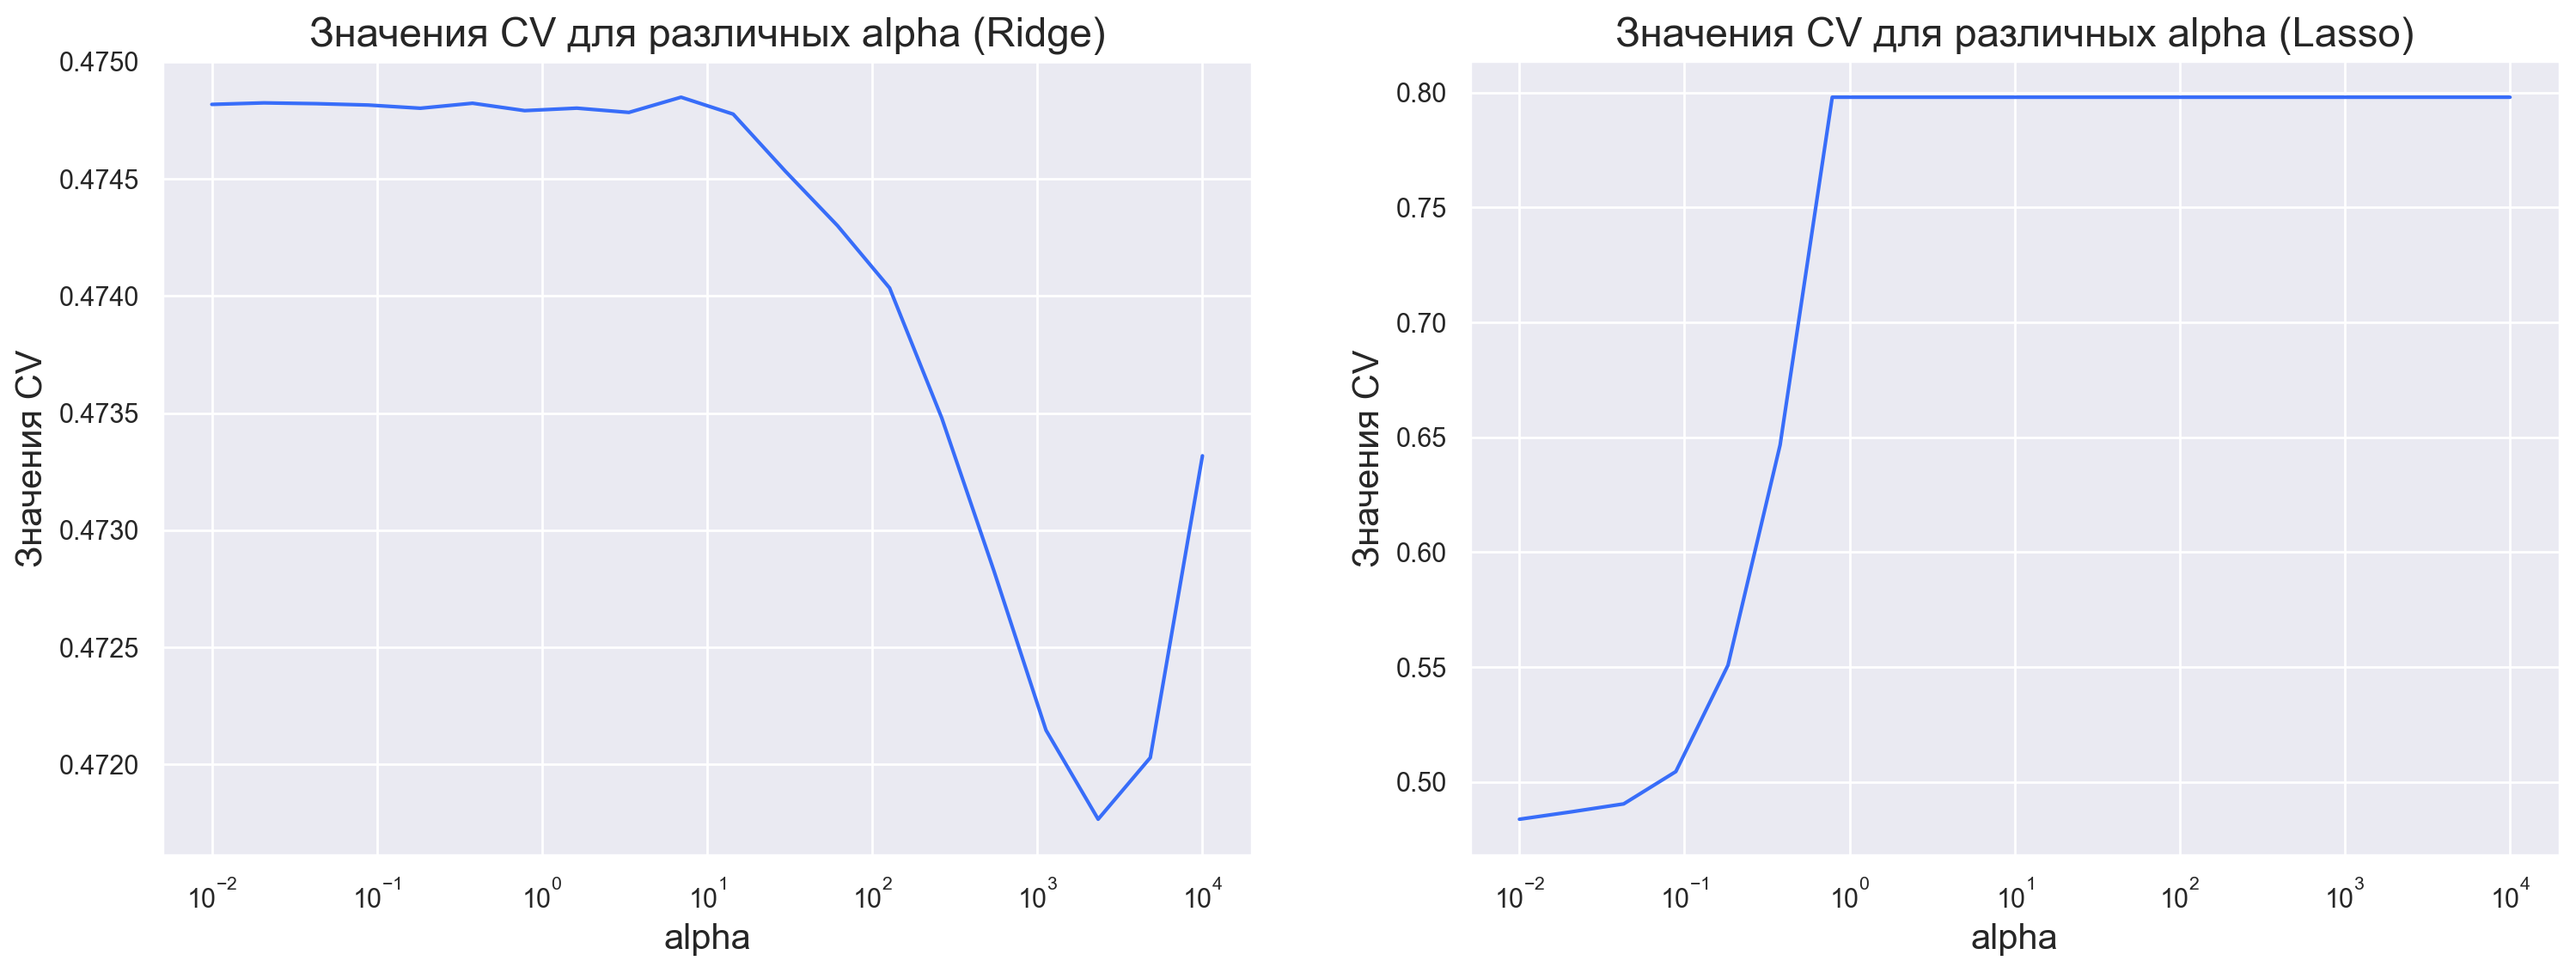

In [44]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.plot(alphas, -searcher_ridge.cv_results_["mean_test_score"])
plt.title('Значения CV для различных alpha (Ridge)', fontsize=17)
plt.xscale('log')
plt.xlabel('alpha', fontsize=15)
plt.ylabel('Значения CV', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(alphas, -searcher_lasso.cv_results_["mean_test_score"])
plt.title('Значения CV для различных alpha (Lasso)', fontsize=17)
plt.xscale('log')
plt.xlabel('alpha', fontsize=15)
plt.ylabel('Значения CV', fontsize=15)

plt.show()

Если и дальше перебирать $\alpha$ и уменьшать размах сетки, то окажется, что для Ridge-модели лучший коэффициент $\approx 2800$, а для Lasso — $0$. Ну а пока что "переобучим" наши модели с новыми значениями $\alpha_{best}$.

In [45]:
ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

ridge_model = ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

print("Тестовая RMSE (Ridge) = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Тестовая RMSE (Ridge) = 0.4628


In [46]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

lasso_model = lasso_pipeline.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

print("Тестовая RMSE (Lasso) = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Тестовая RMSE (Lasso) = 0.4825


И вуаля: значения ошибки приблизились как друг к другу, так и к ошибке регрессии без регуляризации. Стоит отметить, что риск переобучиться у нес не так уж и велик: хотя у нас явно имеется пара сильно коррелирующих с таргетом и между собой признаков, мы имеем больше миллиона объектов в обучающей выборке, мы работаем с линейным моделями и даже без регуляризации веса получаются небольшими.

In [47]:
plain_model_coefs = plain_model['regression'].coef_.tolist()

features = plain_pipeline.named_steps['ohe_and_scaling'].get_feature_names_out()
coefs = plain_model['regression'].coef_

coef_df = pd.DataFrame({'feature': features, 'coefficient': coefs})

max_coef = coef_df.loc[coef_df['coefficient'].idxmax()]
min_coef = coef_df.loc[coef_df['coefficient'].idxmin()]

print("Минимальный коэффициент %.4f у признака %s" % (min_coef['coefficient'], min_coef['feature']))
print("Максимальный коэффициент %.4f у признака %s" % (max_coef['coefficient'], max_coef['feature']))

Минимальный коэффициент -2.1802 у признака ohe__pickup_region_8
Максимальный коэффициент 1.4891 у признака ohe__dropoff_region_3


А ещё оказывается, что веса некоторых регионов на порядок больше, чем высчитанные нами медианная скорость или манхэттенское расстояние. В этом кроется проблема такого большого количества one-hot-encoded признаков, и это наверняка можно обойти, объединив некоторые регионы в один, или уменьшив количество регионов, или как-то иначе — как говорится, оставим это читателю в качестве упражнения.

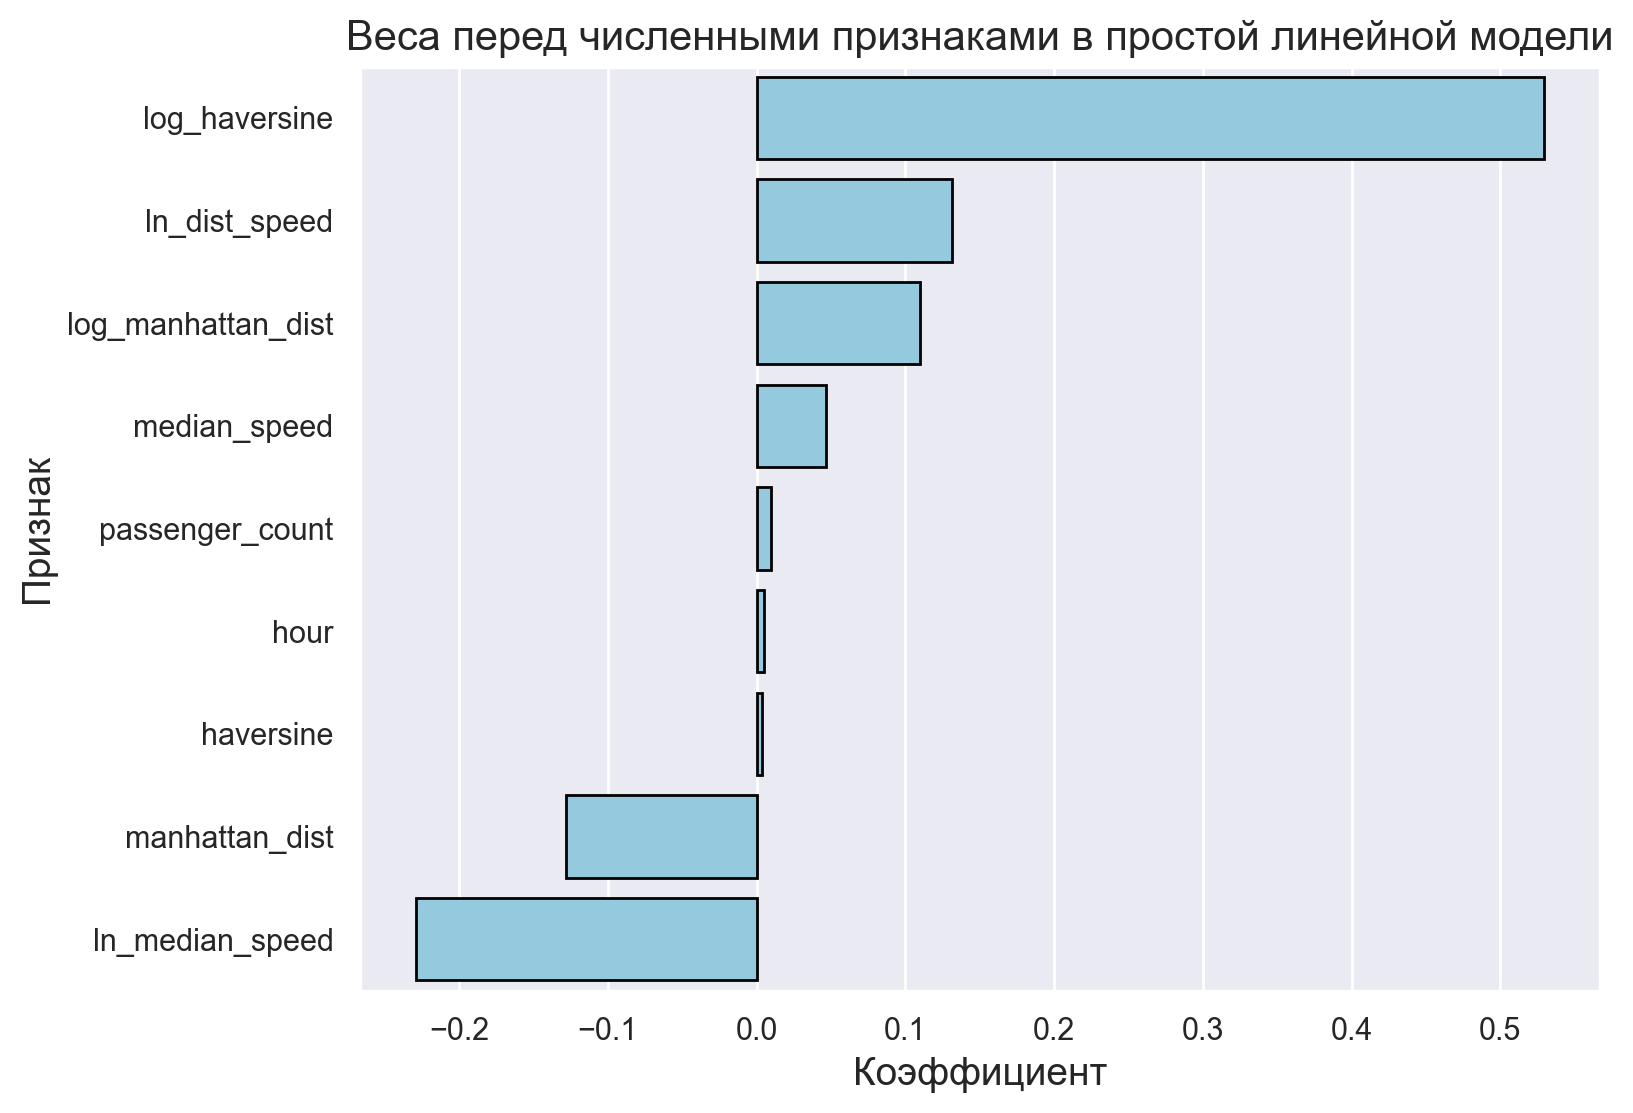

In [48]:
weights_for_numeric = coef_df[coef_df['feature'].apply(lambda x: 'scaling' in x)]
weights_for_numeric = weights_for_numeric.sort_values(by='coefficient', ascending=False)
weights_for_numeric['feature'] = weights_for_numeric['feature'].apply(lambda x: x.replace('scaling__', '') )

sns.barplot(data=weights_for_numeric, x='coefficient', y='feature', color='skyblue', edgecolor='black')
plt.title('Веса перед численными признаками в простой линейной модели', fontsize=15)
plt.xlabel('Коэффициент', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.show()

Осталось не забыть, что мы предсказываем логарифм времени, а не само время, и перед отправкой решения в соревнование добавить преобразование предсказаний $y_{pred} \to e^{y_{pred}} - 1$.

---

На этом моя исследовательская работа завершается, надо ехать дальше. Если у вас появились какие-либо предложения по поводу этого ноутбука, буду рад обсудить лично — мои контакты есть в профиле на гите. Спасибо за внимание!

![](warm_hugs.jpg)